In [50]:
%matplotlib widget

In [51]:
import igl
import meshplot as mp
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')

In [52]:
def make_beam_mesh(width, height, shape):
    x0 = -width/2.0
    y0 = -height/2.0
    I  = shape[0]
    J  = shape[1]
    dx = width/float(I)
    dy = height/float(J)
    V = np.zeros(((I+1)*(J+1),2),dtype=np.float64)
    for j in range(J+1):
        for i in range(I+1):
            k = i + j*(I+1)
            V[k,0] = x0 + i*dx
            V[k,1] = y0 + j*dy
    T = np.zeros((2*I*J,3),dtype=np.int32)
    for j in range(J):
        for i in range(I):
            k00 = (i  ) + (j  )*(I+1)
            k01 = (i+1) + (j  )*(I+1)
            k10 = (i  ) + (j+1)*(I+1)
            k11 = (i+1) + (j+1)*(I+1)
            e = 2*(i + j*I)
            if (i+j)%2:
                T[e,  :] = (k00,k01,k11)
                T[e+1,:] = (k00,k11,k10)
            else:
                T[e,  :] = (k10,k00,k01)
                T[e+1,:] = (k10,k01,k11)                    
    return V, T

def compute_triangle_areas(V,T):
    E = len(T) # Total number of triangles in the mesh
    A = np.zeros((E,),dtype=np.float64)
    for e in range(E):
        # Get triangle indices
        i = T[e,0]
        j = T[e,1]
        k = T[e,2]
        # Get triangle coordinates
        xi = V[i,0]
        xj = V[j,0]
        xk = V[k,0]
        yi = V[i,1]
        yj = V[j,1]
        yk = V[k,1]    
        # Find side vectors
        lx1 = xk - xj
        ly1 = yk - yj
        lx2 = xi - xj
        ly2 = yi - yj
        # Compute area
        A[e] = (lx1*ly2 - lx2*ly1) / 2.0
    return A

In [53]:
def compute_elasticity_matrix(Ey, ν):
    D  = Ey / (1 - ν**2) * np.array([[1, ν, 0], [ν, 1, 0], [0, 0, (1 - ν) / 2]])
    return D

def compute_stiffness_matrix(V, T, D):
    N = len(V) # Total number of nodes in the mesh
    E = len(T) # Total number of triangles in the mesh

    Ke = np.zeros((6,   E*6), dtype=np.float64)
    K  = np.zeros((N*2, N*2), dtype=np.float64)

    A = compute_triangle_areas(V, T)

    # Now compute element stiffness matrices
    for e in range(E):
        # Get triangle indices
        i = T[e,0]  
        j = T[e,1]  
        k = T[e,2]  
        # Get triangle coordinates
        xi = V[i,0]
        xj = V[j,0]
        xk = V[k,0]
        yi = V[i,1]
        yj = V[j,1]
        yk = V[k,1]
        
        # Compute spatial gradients of the barycentric coordinates
        A_ijk = A[e]
        
        D_Ni_x = -(yk - yj) / (2 * A_ijk)
        D_Nj_x = -(yi - yk) / (2 * A_ijk)
        D_Nk_x = -(yj - yi) / (2 * A_ijk)
        
        D_Ni_y = (xk - xj) / (2 * A_ijk)
        D_Nj_y = (xi - xk) / (2 * A_ijk)
        D_Nk_y = (xj - xi) / (2 * A_ijk) 
        
        # Compute the B matrix
        B = np.array([[D_Ni_x,  0,      D_Nj_x, 0,      D_Nk_x, 0     ],
                    [0,       D_Ni_y, 0,      D_Nj_y, 0,      D_Nk_y],
                    [D_Ni_y,  D_Ni_x, D_Nj_y, D_Nj_x, D_Nk_y, D_Nk_x]])
            
        # Compute element stiffness matrix and store it in Ke array
        Ke[:, 6*e:6*e+6] = B.T @ D @ B * A_ijk
        
    # Now do assembly process of global stiffness matrix
    for e in range(E):
        # Get global triangle vertex indices
        i = T[e,0]  
        j = T[e,1]  
        k = T[e,2]    
        # Local order of vertex coordinates is i_x, i_y, j_x j_y, k_x, and  k_y. 
        # This is how local vertex indices (0,1,2,..,5) are mapped to global vertex
        # indices
        gidx = [i, N + i, j, N + j, k, N + k]
        # Now we can add the element stiffness matrix to the global matrix using
        # our local-global vertex index mapping.
        
        # TODO - assemble Ke into global K matrix
        for p in range(6):
            for q in range(6):
                K[gidx[p], gidx[q]] += Ke[p, e*6 + q]
    
    return K

def plot_stiffness_matrix(K, title = None, plot_eigenvalues = False):
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.spy(K);
        ax.set_title(f'Fill pattern of stiffness matrix ({title})');
        ax.set_ylabel('Row index');
        ax.set_xlabel('Column index');
        plt.show()

        
        fig = plt.figure()
        d, _ = np.linalg.eig(K)
        plt.plot(np.sort( d ), '.', ms = 1);
        ax.set_title(f'Eigenvalues of stiffness matrix ({title})');
        ax.set_xlabel('Eigenvalue Index')
        ax.set_ylabel('Value');
        plt.show()
            
def solve_linear_system(V, K, f, boundary_indices, boundary_values):
    F = np.setdiff1d(np.arange(2*N), boundary_indices)
    
    u = np.zeros(f.shape, dtype=np.float64)
    u[boundary_indices] = boundary_values
    KFF = K[F, :][:, F]
    fF  = f[F]
    u[F] = np.linalg.solve(KFF, fF)

    x = V[:, 0] + u[0:N]
    y = V[:, 1] + u[N:2*N]
    return u, x, y

def plot_displacement(V, T, u, x, y, title, color, problem, load = None):
    fig = plt.figure()
    plt.triplot(V[:, 0], V[:, 1], T, color='black', alpha=0.15, lw=0.5)
    plt.quiver(V[:, 0], V[:, 1], u[0:N], u[N:2*N], scale=1, scale_units='xy', color=color, width=0.003, alpha=0.5)
    plt.triplot(x, y, T, color='black', lw=0.8)
    if problem == 'cantilever':
        plt.title(f'Displacement of cantilever with load {np.abs(load/1e3):.0f} kN ({title})')
    elif problem == 'settling':
        plt.title(f'Displacement due to gravity ({title})')
    else:
        raise ValueError('Invalid problem type')
    plt.axis('equal')
    plt.show()


In [54]:

def cantilever_boundary_conditions(V, K, ρ, load, g = 0):
    N = len(V)
    f = np.zeros((2*N,),dtype=np.float64)
    f[1::2] = - g * ρ

    right_boundary_indices = np.array(np.where(V[:,0] == V[:,0].max()), dtype=np.int32).flatten() + N
    f[right_boundary_indices] = load
        
    left_boundary_xindices = np.array(np.where(V[:,0] == V[:,0].min()), dtype=np.int32).flatten()
    left_boundary_yindices = left_boundary_xindices + N

    left_boundary_indices = np.hstack((left_boundary_xindices, left_boundary_yindices))
    left_boundary_values  = np.zeros(left_boundary_indices.shape, dtype=np.float64)

    F = np.setdiff1d(np.arange(2*N), left_boundary_indices)

    for i, (left_boundary_index, left_boundary_value) in enumerate(zip(left_boundary_indices, left_boundary_values)):
        # TODO - add boundary conditions here    
        # Moving known values to the right hand side
        f[F] -= K[F, left_boundary_index] * left_boundary_value
        f[left_boundary_index] = left_boundary_value
        
        # Inserting boundary conditions into K
        K[left_boundary_index, :] = 0
        K[left_boundary_index, left_boundary_index] = 1
    return K, f, left_boundary_indices, left_boundary_values
    
    
def solve_cantilever_problem(V, T, Ey, ν, ρ, load, title, color, do_plot_displacement = True, do_plot_stiffness_matrix = False):
    D = compute_elasticity_matrix(Ey, ν)
    K = compute_stiffness_matrix(V, T, D)
    K, f, left_boundary_indices, left_boundary_values = cantilever_boundary_conditions(V, K, ρ, load)
    
    if do_plot_stiffness_matrix:
        plot_stiffness_matrix(K, title)
    
    u, x, y = solve_linear_system(V, K, f, left_boundary_indices, left_boundary_values)
    
    if do_plot_displacement:
        plot_displacement(V, T, u, x, y, title, color, load = load, problem = 'cantilever')


In [55]:
def settling_boundary_conditions(V, K, ρ, g):
    N = len(V)
    f = np.zeros((2*N,),dtype=np.float64)
    f[1::2] = -g * ρ
        
    lower_boundary_xindices = np.array(np.where(V[:,1] == V[:,1].min()), dtype=np.int32).flatten()
    lower_boundary_yindices = lower_boundary_xindices + N

    lower_boundary_indices = np.hstack((lower_boundary_xindices, lower_boundary_yindices))
    lower_boundary_values  = np.zeros(lower_boundary_indices.shape, dtype=np.float64)

    F = np.setdiff1d(np.arange(2*N), lower_boundary_indices)

    for i, (lower_boundary_index, lower_boundary_value) in enumerate(zip(lower_boundary_indices, lower_boundary_values)):
        # add boundary conditions here    
        # Moving known values to the right hand side
        f[F] -= K[F, lower_boundary_index] * lower_boundary_value
        f[lower_boundary_index] = lower_boundary_value
        
        # Inserting boundary conditions into K
        K[lower_boundary_index, :] = 0
        K[lower_boundary_index, lower_boundary_index] = 1
    return K, f, lower_boundary_indices, lower_boundary_values
        
        
def solve_settling_problem(V, T, Ey, ν, ρ, title, color, do_plot_displacement = True, do_plot_stiffness_matrix = False):
    D = compute_elasticity_matrix(Ey, ν)
    K = compute_stiffness_matrix(V, T, D)
    K, f, lower_boundary_indices, lower_boundary_values = settling_boundary_conditions(V, K, ρ, g)
    
    if do_plot_stiffness_matrix:
        plot_stiffness_matrix(K, title)
    
    u, x, y = solve_linear_system(V, K, f, lower_boundary_indices, lower_boundary_values)
    
    if do_plot_displacement:
        plot_displacement(V, T, u, x, y, title, color, problem = 'settling')

# Experiment 1: Cantilever

In [56]:
doExp1 = True

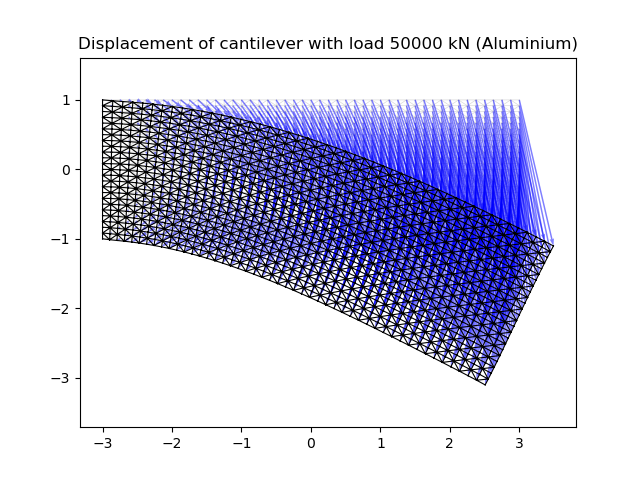

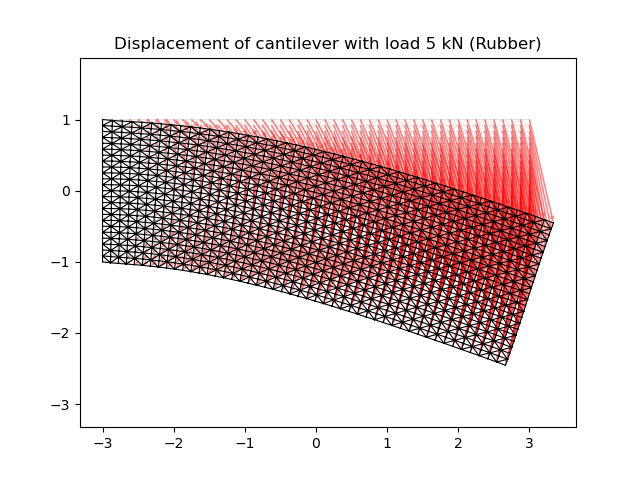

In [57]:
if doExp1:
    Ey_alu = 69e9  # Young modulus for aluminium
    ν_alu = 0.3    # Poisson ration for aluminium
    ρ_alu = 2700 # Density of aluminium in kg/m^3

    Ey_rub = 0.01e9 # Young modulus for rubber
    ν_rub = 0.49 # Poisson ratio for rubber
    ρ_rub = 1100 # Density of rubber in kg/m^3

    Es = [Ey_alu, Ey_rub]
    νs = [ν_alu, ν_rub]
    ρs = [ρ_alu, ρ_rub]

    loads = [-5e7, -5e3] # Load applied to the cantilever in N

    titles = ['Aluminium', 'Rubber']
    colors = ['blue', 'red']

    Ks = []
    fs = []
    us = []

    for i, (Ey, ν, ρ, load, title, color) in enumerate(zip(Es, νs, ρs, loads, titles, colors)):
        width = 6.0
        height = 2.0
        I = 12 * 4
        J = 6 * 4
        V, T = make_beam_mesh(width, height, (I, J))

        N = len(V)
        solve_cantilever_problem(V, T, Ey, ν, ρ, load, title, color)
            

# Experiment 2: Settling under gravity

In [58]:
doExp2 = True

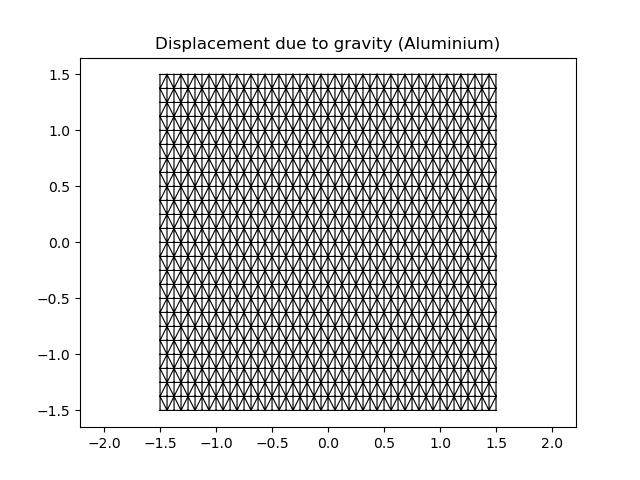

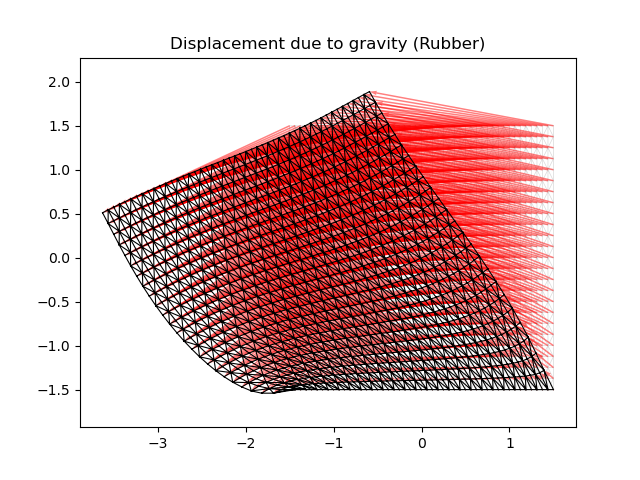

In [60]:
if doExp2:
    g = 9.81 #m/s^2

    Ey_alu = 69e9  # Young modulus for aluminium
    ν_alu = 0.3    # Poisson ration for aluminium
    ρ_alu = 2700 # Density of aluminium in kg/m^3

    Ey_rub = 0.01e9 # Young modulus for rubber
    ν_rub = 0.49 # Poisson ratio for rubber
    ρ_rub = 1100 # Density of rubber in kg/m^3

    Es = [Ey_alu, Ey_rub]
    νs = [ν_alu, ν_rub]
    ρs = [ρ_alu, ρ_rub]

    titles =['Aluminium','Rubber']
    colors =['blue', 'red']
    
    width = 3.0
    height = 3.0
    I = 12 * 4
    J = 6 * 4
    V, T = make_beam_mesh(width, height, (I, J))
    N = len(V)

    for i, (Ey, ν, ρ, title, color) in enumerate(zip(Es, νs, ρs, titles, colors)):
        solve_settling_problem(V, T, Ey, ν, ρ, title, color)
            

# Experiment 3: Bridge stress

SyntaxError: invalid syntax (3788637299.py, line 1)

In [ ]:
poly = np.zeros((9,2),dtype=np.float64)
poly[0,:] = vec2(-1.0,-1.0)
poly[1,:] = vec2(-0.5,-1)
poly[2,:] = vec2(-0.5,0.5)
poly[3,:] = vec2(0.5,0.5)
poly[4,:] = vec2(0.5,-1)
poly[5,:] = vec2( 1.0,-1.0)
poly[6,:] = vec2( 1.0, 1.0)
poly[7,:] = vec2(-1.0, 1.0)
poly[8,:] = vec2(-1.0,-1.0)